In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [36]:
path = "/kaggle/input/plantvillage-dataset/color"

In [37]:
# Loop through each class folder
for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        # Count only files (ignore subfolders, if any)
        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [38]:
import os
import shutil
import random
from pathlib import Path

# Reproducibility (optional)
random.seed(42)

# Paths
source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Collect classes and counts
class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)

# Build balanced dataset:
kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)

    # Skip classes with fewer than 350 images
    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    # List image files and sample to exactly 350
    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # If count == 350 this returns all, otherwise a downsample to 350
    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)

Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [39]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),      # Resize and crop for augmentation
    transforms.RandomHorizontalFlip(),      # Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply test transformation to validation and test sets

val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [40]:
class_names = dataset.classes
num_classes = len(class_names)

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FIX: Subset -> access underlying dataset
class_names = train_dataset.dataset.classes
total_class = len(class_names)

learning_rate = 0.0001

model = models.resnet50(pretrained=True)

# Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# Replace head
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)

model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

summary(model, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [42]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [43]:
from tqdm import tqdm  
from torch.cuda.amp import autocast, GradScaler 
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim

num_epochs = 50  


model = models.vgg16(pretrained=True)


for p in model.features.parameters():
    p.requires_grad = False


in_features = model.classifier[-1].in_features  
model.classifier[-1] = nn.Linear(in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()


optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

early_stopping = EarlyStopping(patience=5)
train_losses, val_losses = [], []


scaler = GradScaler(enabled=(device.type == "cuda"))

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # ---------- Train ----------
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()


        with autocast(enabled=(device.type == "cuda")):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if device.type == "cuda":
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        train_loss += loss.item()

    # ---------- Validate ----------
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            with autocast(enabled=(device.type == "cuda")):
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_36/3252443154.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == "cuda"))


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_36/3252443154.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):
Validation:   0%|          | 0/79 [00:00<?, ?it/s]         /tmp/ipykernel_36/3252443154.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Train Loss: 1.3543, Validation Loss: 0.6708
Epoch 2/50


Train Loss: 0.8979, Validation Loss: 0.8576
Epoch 3/50


Train Loss: 0.9006, Validation Loss: 0.6259
Epoch 4/50


Train Loss: 0.7843, Validation Loss: 0.5217
Epoch 5/50


Train Loss: 0.7717, Validation Loss: 0.4879
Epoch 6/50


Train Loss: 0.7047, Validation Loss: 0.5990
Epoch 7/50


Train Loss: 0.8551, Validation Loss: 0.7564
Epoch 8/50


Train Loss: 0.8389, Validation Loss: 0.6301
Epoch 9/50


Train Loss: 0.7339, Validation Loss: 0.8734
Epoch 10/50


Train Loss: 0.6823, Validation Loss: 0.5387
Early stopping triggered.


In [44]:

model_save_path = "vgg16_model.pth" 


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to vgg16_model.pth


In [45]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_36/2379966855.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.8657    0.9508    0.9062        61
           1     0.9865    0.8902    0.9359        82
           2     0.9296    0.9565    0.9429        69
           3     0.9831    1.0000    0.9915        58
           4     0.9881    0.9765    0.9822        85
           5     0.9583    0.9857    0.9718        70
           6     0.9091    0.8824    0.8955        68
           7     1.0000    1.0000    1.0000        66
           8     0.8571    0.9231    0.8889        78
           9     1.0000    0.9857    0.9928        70
          10     0.9710    0.9853    0.9781        68
          11     0.9701    0.9701    0.9701        67
          12     0.9848    0.9701    0.9774        67
          13     1.0000    1.0000    1.0000        64
          14     0.9643    1.0000    0.9818        81
          15     0.9545    0.9692    0.9618        65
          16     0.9855    0.9714    0.9784        70
   

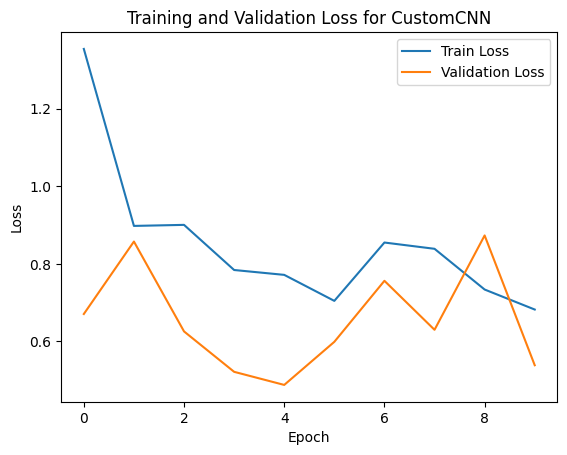

In [46]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_36/1587758096.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=="cuda")):


Testing time: 5.89 sec  |  Throughput: 214.07 samples/sec
Confusion Matrix:
 [[28  0  0 ...  0  0  0]
 [ 3 31  1 ...  0  0  0]
 [ 2  0 32 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  1  0]
 [ 0  0  0 ...  0 43  0]
 [ 0  0  0 ...  0  0 39]]

Confusion Matrix (row-normalized):
[[0.966 0.    0.    ... 0.    0.    0.   ]
 [0.086 0.886 0.029 ... 0.    0.    0.   ]
 [0.059 0.    0.941 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.967 0.033 0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.    0.    ... 0.    0.    0.975]]


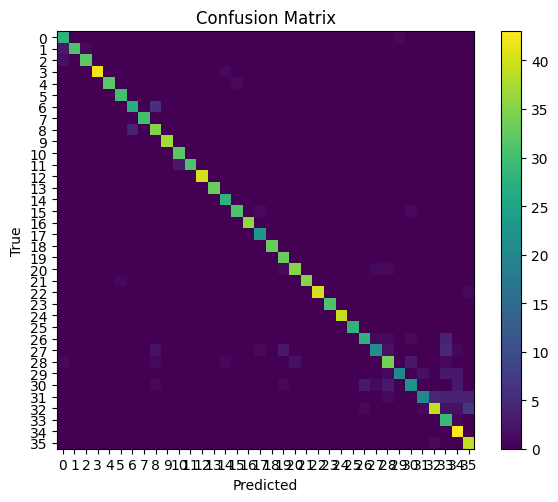

Per-class ROC AUC:
  Class 0: 0.9992
  Class 1: 0.9974
  Class 2: 0.9942
  Class 3: 0.9957
  Class 4: 0.9980
  Class 5: 1.0000
  Class 6: 0.9821
  Class 7: 1.0000
  Class 8: 0.9940
  Class 9: 1.0000
  Class 10: 0.9998
  Class 11: 0.9962
  Class 12: 1.0000
  Class 13: 1.0000
  Class 14: 0.9996
  Class 15: 0.9994
  Class 16: 1.0000
  Class 17: 0.9995
  Class 18: 1.0000
  Class 19: 0.9999
  Class 20: 0.9969
  Class 21: 1.0000
  Class 22: 0.9996
  Class 23: 1.0000
  Class 24: 1.0000
  Class 25: 1.0000
  Class 26: 0.9881
  Class 27: 0.9788
  Class 28: 0.9929
  Class 29: 0.9902
  Class 30: 0.9880
  Class 31: 0.9877
  Class 32: 0.9903
  Class 33: 0.9933
  Class 34: 0.9992
  Class 35: 0.9995
Micro-average ROC AUC: 0.9967
Macro-average ROC AUC: 0.9962


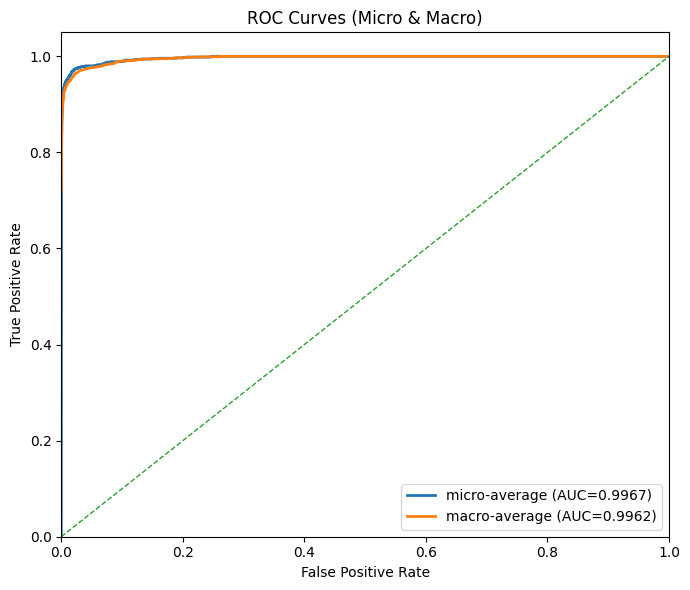

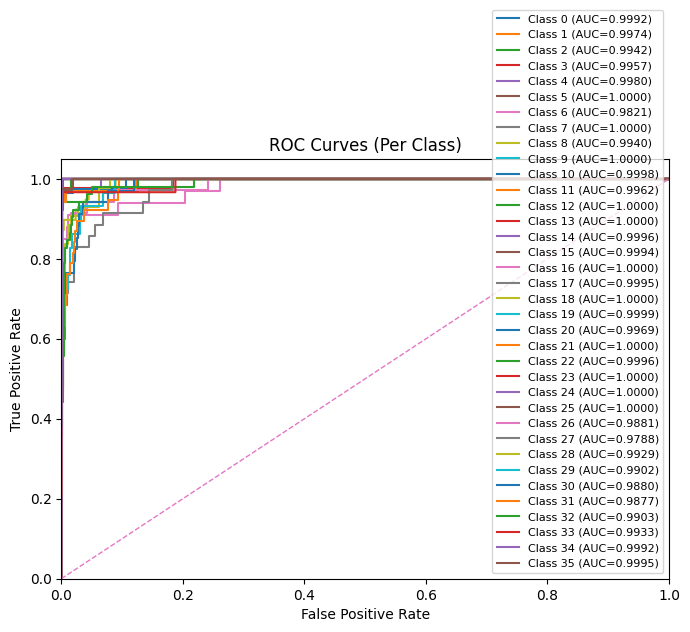


Classification Report (test):
              precision    recall  f1-score   support

           0     0.8235    0.9655    0.8889        29
           1     1.0000    0.8857    0.9394        35
           2     0.9697    0.9412    0.9552        34
           3     1.0000    0.9767    0.9882        43
           4     1.0000    0.9697    0.9846        33
           5     0.9677    1.0000    0.9836        30
           6     0.8710    0.8182    0.8438        33
           7     1.0000    1.0000    1.0000        30
           8     0.7778    0.8974    0.8333        39
           9     1.0000    1.0000    1.0000        37
          10     0.9143    1.0000    0.9552        32
          11     1.0000    0.9118    0.9538        34
          12     1.0000    1.0000    1.0000        40
          13     1.0000    1.0000    1.0000        33
          14     0.9333    1.0000    0.9655        28
          15     0.9688    0.9394    0.9538        33
          16     1.0000    1.0000    1.0000       

In [47]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import (
    confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()

all_logits   = []
all_probs    = []
all_preds    = []
all_labels   = []


loader = test_loader 

t_test_start = time.time()
with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        with autocast(enabled=(device.type=="cuda")):
            logits = model(images)                        
            probs  = F.softmax(logits, dim=1)            

        preds = torch.argmax(probs, dim=1)

        all_logits.append(logits.detach().cpu().numpy())
        all_probs.append(probs.detach().cpu().numpy())
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

t_test_end = time.time()
total_test_time_sec = t_test_end - t_test_start
n_samples = len(all_preds)
print(f"Testing time: {total_test_time_sec:.2f} sec  |  Throughput: {n_samples/total_test_time_sec:.2f} samples/sec")

all_logits = np.concatenate(all_logits, axis=0)
all_probs  = np.concatenate(all_probs, axis=0)
all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

num_classes = all_probs.shape[1]
class_indices = list(range(num_classes))


cm = confusion_matrix(all_labels, all_preds, labels=class_indices)
print("Confusion Matrix:\n", cm)

# simple text view
def print_cm(cm):
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    norm_cm = cm / row_sums
    print("\nConfusion Matrix (row-normalized):")
    with np.printoptions(precision=3, suppress=True):
        print(norm_cm)

print_cm(cm)


plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


y_true_bin = label_binarize(all_labels, classes=class_indices) if num_classes > 2 else all_labels
y_score    = all_probs

if num_classes == 2:
    
    fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
    roc_auc = auc(fpr, tpr)
    print(f"Binary ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Binary)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

else:
  
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in class_indices:
        fpr[c], tpr[c], _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    
    all_fpr = np.unique(np.concatenate([fpr[c] for c in class_indices]))
   
    mean_tpr = np.zeros_like(all_fpr)
    for c in class_indices:
        mean_tpr += np.interp(all_fpr, fpr[c], tpr[c])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print("Per-class ROC AUC:")
    for c in class_indices:
        print(f"  Class {c}: {roc_auc[c]:.4f}")
    print(f"Micro-average ROC AUC: {roc_auc['micro']:.4f}")
    print(f"Macro-average ROC AUC: {roc_auc['macro']:.4f}")

    # Plot micro & macro
    plt.figure(figsize=(7, 6))
    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'micro-average (AUC={roc_auc["micro"]:.4f})')
    plt.plot(fpr["macro"], tpr["macro"], lw=2, label=f'macro-average (AUC={roc_auc["macro"]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Micro & Macro)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    
    plt.figure(figsize=(7, 6))
    for c in class_indices:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f'Class {c} (AUC={roc_auc[c]:.4f})')
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves (Per Class)')
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()


print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))


In [48]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-ukzq6rsj
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-ukzq6rsj
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [49]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

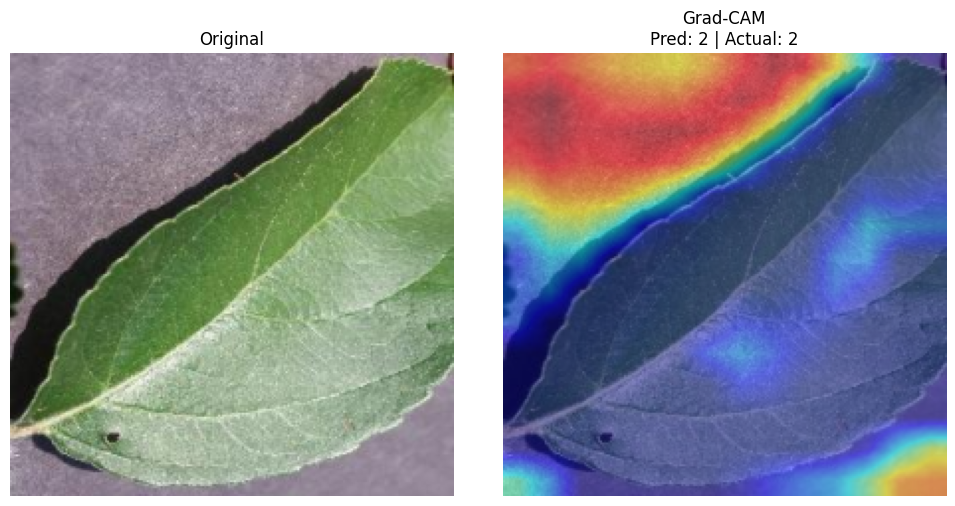

In [52]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

for p in model.features.parameters():
    p.requires_grad_(True)

sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5
original_image_np = original_image_np.clip(0, 1)

target_layers = [model.features[28]]

cam = GradCAM(model=model, target_layers=target_layers)

outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()

targets = [ClassifierOutputTarget(predicted_class)]

grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]

result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)

class_names = getattr(test_dataset, "classes", None) or [str(i) for i in range(outputs.shape[1])]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}")
plt.imshow(result)
plt.axis('off')

plt.tight_layout()
plt.show()


Using device: cuda
Using existing model from notebook context.
Using existing test_dataset from notebook context.
Using existing class_names.


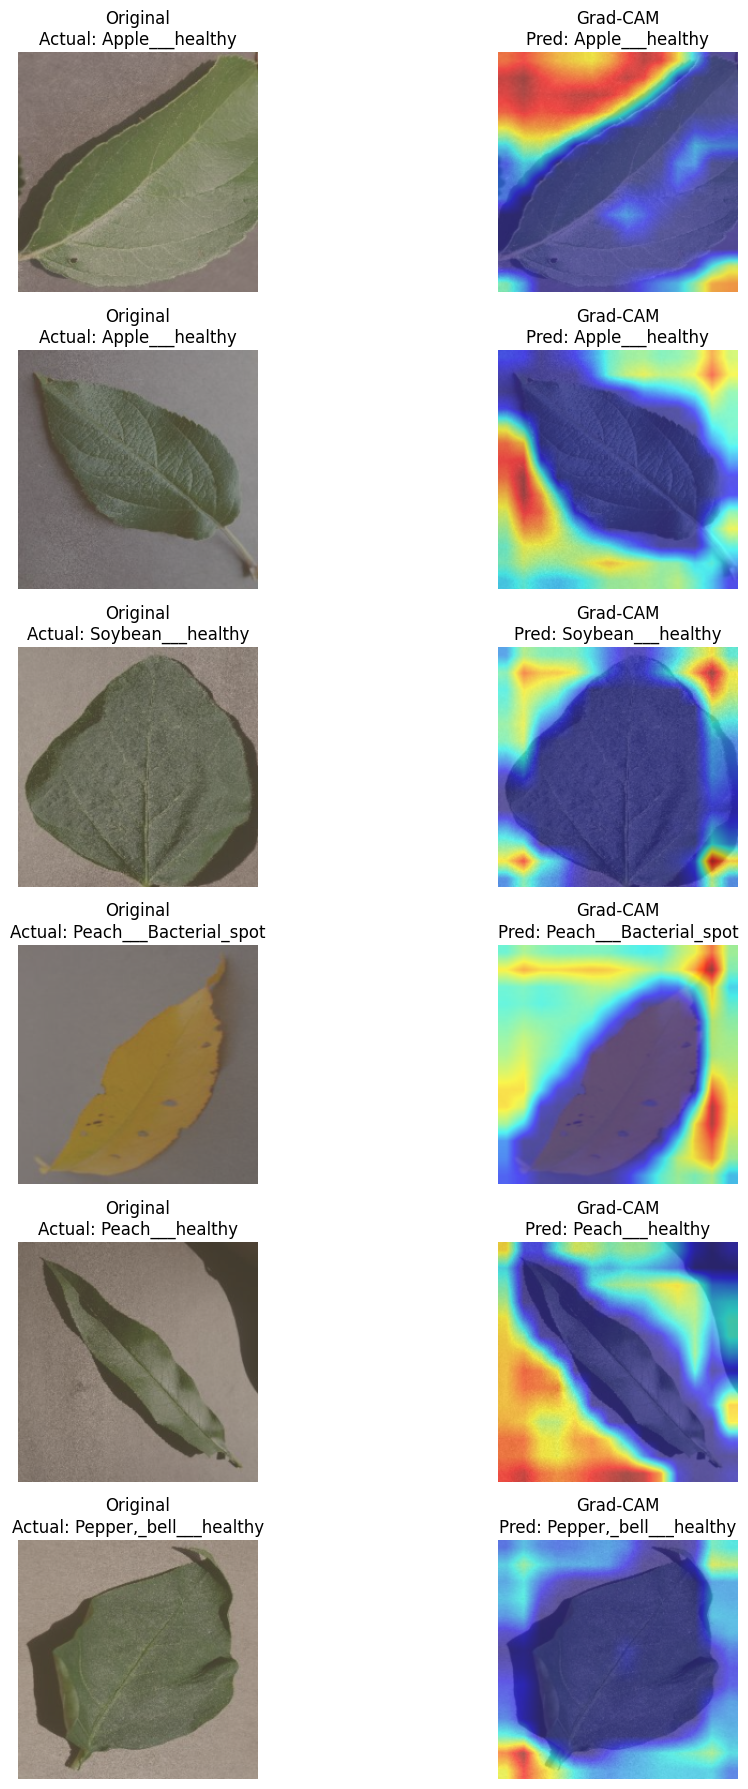

In [50]:


import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models, transforms, datasets
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


TEST_DIR = ""           
WEIGHTS_PATH = ""       
NUM_CLASSES = None      
NUM_IMAGES_TO_SHOW = 6  
FIG_SCALE_PER_ROW = 3  


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


use_existing_model = "model" in globals() and isinstance(globals()["model"], nn.Module)
if use_existing_model:
    model = globals()["model"]
    print("Using existing model from notebook context.")
    
else:
    print("Building VGG16 model…")
    model = models.vgg16(pretrained=True)
   
    if NUM_CLASSES is not None:
        in_features = model.classifier[-1].in_features  
        model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)

    if WEIGHTS_PATH and os.path.isfile(WEIGHTS_PATH):
        state = torch.load(WEIGHTS_PATH, map_location="cpu")
       
        state_dict = state.get("state_dict", state)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded weights from: {WEIGHTS_PATH}")

model.eval().to(device)


use_existing_dataset = "test_dataset" in globals()
if use_existing_dataset:
    test_dataset = globals()["test_dataset"]
    print("Using existing test_dataset from notebook context.")
else:
    if not TEST_DIR:
        raise ValueError("TEST_DIR is empty and no existing test_dataset found. "
                         "Either set TEST_DIR to an ImageFolder path or provide test_dataset in the notebook.")
   
    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])
    test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transform)
    print(f"Built test_dataset from: {TEST_DIR}")


if "class_names" in globals():
    class_names = globals()["class_names"]
    print("Using existing class_names.")
else:
    class_names = getattr(test_dataset, "classes", [str(i) for i in range(NUM_CLASSES or 0)])
    print(f"class_names: {class_names}")


for p in model.features[24:].parameters():
    p.requires_grad_(True)

target_layers = [model.features[28]]


IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denorm_to_numpy(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """img_tensor: CxHxW (Torch tensor). Returns HxWxC numpy in [0,1]."""
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = img * std + mean
    return img.clip(0, 1)


rows = NUM_IMAGES_TO_SHOW
cols = 2  

plt.figure(figsize=(12, rows * FIG_SCALE_PER_ROW))

cam = GradCAM(model=model, target_layers=target_layers)

for i in range(NUM_IMAGES_TO_SHOW):
    img_t, label = test_dataset[i]
    x = img_t.unsqueeze(0).to(device)


    with torch.no_grad():
        logits = model(x)
        pred = int(logits.argmax(dim=1).item())

    
    targets = [ClassifierOutputTarget(pred)]

   
    grayscale_cam = cam(input_tensor=x, targets=targets, eigen_smooth=True)
    heatmap = grayscale_cam[0]  
    
    orig = denorm_to_numpy(img_t)

    
    overlay = show_cam_on_image(orig, heatmap, use_rgb=True)


    plt.subplot(rows, cols, i * cols + 1)
    plt.imshow(orig)
    plt.axis('off')
    true_name = class_names[label] if (0 <= label < len(class_names)) else str(label)
    plt.title(f"Original\nActual: {true_name}")


    plt.subplot(rows, cols, i * cols + 2)
    plt.imshow(overlay)
    plt.axis('off')
    pred_name = class_names[pred] if (0 <= pred < len(class_names)) else str(pred)
    plt.title(f"Grad-CAM\nPred: {pred_name}")

plt.tight_layout()
plt.show()